<a href="https://colab.research.google.com/github/Strojove-uceni/23206-final-sign-language-recognition-in-video/blob/main/Final_SU2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rozpoznávání znakové řeči
Autoři: Jiří Nábělek, David Rendl

---
**Abstrakt:** Pro závěrečný projekt do předmětu SU2 jsme se rozhodli natrénovat neuronovou síť k rozpoznávání a přepis znakové řeči ve videu a v reálném čase. Znaková řeč je stále pro většinu lidí poměrně nepřístupná záležitost a málokdo má motivaci se jí učit, přesto je znakový jazyk  klíčovým prostředkem komunikace pro mnoho lidí. Naši cílem je vytvořit neuronovou síť, který dokáže rozpoznávat znakový jazyk z videa, což představuje důležitý krok k překlenutí komunikačního rozdílu mezi neslyšícími a lidmi, kteří znakovou řeč neovládají. Jeho použití může výrazně zlepšit vzájemnou interakci a pomoci budovat most porozumění a respektu mezi oběma skupinami. Tento překlad je obzvláště obtížná úloha, každý člověk může znakovat trochu odlišně, zároveň jsou gesta závislá na pohybu, nejedná se, až na výjimky, o statická gesta. Tento fakt předurčuje komplikovanost modelu který dokáže znaky identifikovat. Povedlo se nám natrénovat neuronovou síť, která rozpoznává 250 znaků s přesností $69\%$ a může tvořit odrazový můstek pro vývoj komplexnější neurnových sítí, které zvládnou klasifikovat více slov.

# Metodologie

Zatímco rozpoznávání statických gest je již prakticky vyřešená úloha, rozpoznávání znakové řeči je o poznání komplexnější. Jednotlivé znaky jsou totiž z části určené pohybem, a zachytit tento pohyb je klíčové pro správnou klasifikaci. V průběhu řešení jsme otestovali několik různých přístupů. Zásadní je samotné zpracování dat a reprezentace jednotlivých gest. V tomto směru jsme nejprve vyzkoušeli tenzorovou reprezentaci, kdy jednotlivé snímky ze sekvence skládáme na sebe. Namísto samotných snímků jsme použili matici která vznikne ze vzdáleností každého vybraného bodu na těle s každým. Významné body byly vybrány z obličeje (21 bodů) a z rukou (21 bodů). Další variantou bylo skládání souřadnic významných bodů za sebe, a jednotlivé snímky použít jako řádky matice. Výsledná reprezentace by tedy byla matice rozměru Počet snímků x (Počet významných bodů x 3). Z tohoto uspořádání dat plyne i poslední reprezentace, a sice TSSI (Tree Structure Skeleton Image). Myšlenka je podobná, akorát namísto skládání souřadnic za sebe vytváříme 3 kanálový obraz, kde každý kanál koresponduje s danou souřadnicí (x,y,z) významného bodu.

Ke konstrukci modelu jsme použili framework PyTorch Lightning, který nám umožnil implementovat poměrně snadno i složitější metody pro efektivní trénování, jako například Automatic Mixed Precision (AMP) a Accumulated Gradient Batches. Tyto metody byly zásadní kvůli omezené paměti GPU. Všechny jednotlivé části potřebné pro trénování a testování jsme oddělili do samostatných souborů, tedy Dataset a DataModule samostatně, modely samostatně a samotné spouštění v samostatném souboru. To nám umožnilo efektivní dělení práce, modely a datasety stačilo importovat, a zatímco jeden člověk ladil hyperparametry a trénoval modely, druhý mohl bez obtíží přidávat další modely. Tento přístup také zpřehlednil celý vývoj modelu.

Trénování probíhalo na řadě systémů. V praxi jsme používali Nvidia A100 (Google Colab Pro), Nvidia GTX 1050Ti, Nvidia RTX A1000 a Nvidia Quatro P5000. To jsme zohlednili přidáním parametru "number of workers" pro co nejefektivnější trénování na každém systému.  Největší problém byl s VRAM, i přesto že Colab Pro nám umožnil využít grafickou kartu Nvidia A100, pro každý běh je vyhrazeno pouze 16 Gb paměti. To byl primární důvod pro využití AMP a Gradient Accumulatiion, ovšem s těmito metodami jsme už grafickou kartu A100 nepotřebovali a mohli jsme trénovat na dostupnějších systémech. Dalším problémem Google Colab bylo samotné úložiště. Dataset je velký, a jakákoliv manipulace s ním je obtížná, pro jeden experiment s reprezentací dat jsme potřebovali 1,5 TB dat, což je v cloudovém prostředí nerealistické. Nakonec jsme Google Colab opustili úplně.

K zaznamenávání výsledků jsme použili Weigts and Biases.

Pro předzpracování datasetu, jeho vizualizaci a čištění jsme vytvořili třídu ParquetProcess v souboru processing. Pro třídění, načítání a ukládání souborů v požadovaném formátu jsme vytvořili buffer s třídou ParquetData.

Vybrat vhodnou architekturu představovalo další problém. Celkem jsme naimplementovali a otestovali 4 konvoluční modely, vlastní verzi ResNet modifikovanou pro 3D data, LSTM a GRU, testovali jsme i možnost použít kombinaci LSTM a 3DCNN. Dále jsme naimplementovali 2D konvoluční sítě (a doplnit co ještě všechno, vím kulový co všechno jsme udělali.). Nakonec jsme vybrali (idk model). Jeho zásadní výhodou je že ve srovnání s např. 3D konvoluční sítí je mnohem menší, méně náročný na paměť a tak je trénování rychlejší a tedy lze experimentovat s hyperparametry v rychlém sledu. Dalším důvodem proč jsme zvolili tento přístup je, že cílem je inference v reálném čase. S menším modelem je mnohem jednoduší docílit použitelné snímkovací frekvence při současné predicky gest. Inference v reálném čase je naimplementovaná v souboru LiveFeed_v4. Je zde využitá předchozí třída ParquetProcess pro extrakci významných bodů a k výpočtu příznaků. Jelikož je zásadní udržet snímkovací frekvenci alespoň na 24 snímcích za sekundu, tak celý proces běží na 2 vláknech, jedno pro získávání snímků z kamery a druhé pro extrakci příznaků, inference samotná běží na GPU.

**Upozornění:** Live feed musí běžet lokálně, Colab nemá přístup k webkameře jinak než pouhým pořízením jednoho snímku, pro otestování predikcí v reálném čase je tedy potřeba stáhnout kód.

# Dataset
---
Dataset se znaky v nejrozšířenější variantě znakové řeči, American Sign Language (dále jen ASL), jsme stáhli z https://www.kaggle.com/competitions/asl-signs, kde byla tato úloha původně zadána jako soutěž od Google. Soubor s daty obsahuje 250 slov, vyznakovaných několikrát 21 dobrovolníky. Celkem je k dispozici 94 456 souborů ve formátu parquet. Dále je k dispozici `.csv` soubor který přiřazuje názvy jednotlivých parquet souborů ke konkrétním slovům. Do CSV souboru jsme doplnili sloupec s délkou každé nahrané sekvence, jelikož některé soubory vykazovali problém s přílišnou délkou, nahrávání bylo spuštěné příliš brzy nebo ukončeno pozdě, a tak některé sekvence byly dlouhé i 2000 snímků. To by velmi zkomplikovalo proces učení.

# Návod pro import dat (nutné pro spuštění)

Pro správné spuštění kódu je nejprve potřeba nastavit přístup k datům podle postupu:


1.   Nejprve je potřeba rozkliknout následující link, aby byl přidán do sdílených složek na Vašem google drive (je potřeba přihlášení ke google účtu).
https://drive.google.com/drive/folders/1c46iuMiJbgvkJNC5ljYBMehzId_srUJE?usp=sharing
2.   Sdílenou složku by pak mělo být možné najít na Disku Google na kartě "Sdíleno se mnou".
3.   Klikněte na složku pravým tlačítkem myši, vyberte možnost "Uspořádat" a pak na "Přidat zástupce".
4.   Vyberte umístění hlavního adresáře na Vašem disku (pokud vyberete jinou složku, tak je potřeba upravit proměnnou `path` níže) a klikněte na "Přidat zástupce".

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

path = "/content/drive/MyDrive/ASL-sign_data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Načteme nejprve `DataFrame`, ve kterém jsou uložené informace o cestě k `.parquet` souboru, název znaku, počet framů v souboru, `id` znakující osoby a znakované sekvence.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
df_train = pd.read_csv(path + "/train_mod.csv", sep=",")
df_train.head()

,Unnamed: 0,path,participant_id,sequence_id,sign,length_frames
0,0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,70.0
1,1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,34.0
2,2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,426.0
3,3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,37.0
4,4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,55.0


Při rychlém prozkoumání přiloženého CSV souboru můžeme vidět, že $75\%$ `.parquet` souborů má počet framů nižší než 140. Pro urychlení a zjednodušenní trénování budeme tedy pracovat pouze se soubory jejichž délka je do 140 framů.

In [ ]:
df_train.describe()

Lepší představu o rozdělení počtu framů může dále poskytnout přiložený BoxPlot.

In [ ]:
plt.boxplot(df_train.length_frames.values)
plt.show()

Samotné parquet soubory obsahují "landmarks", významné body na rukou a na obličeji, získané během nahrávání pomocí knihovny mediapipe. Body jsou reprezentované pomocí indexu, který je pevně daný knihovnou mediapipe, a součadnic každého bodu v obrazu.

In [ ]:
df = pd.read_parquet(path + "/train_landmark_files/2044/4294708045.parquet")
df.head()

,frame,row_id,type,landmark_index,x,y,z
0,19,19-face-0,face,0,0.466062,0.414388,-0.046074
1,19,19-face-1,face,1,0.458775,0.374097,-0.069165
2,19,19-face-2,face,2,0.462069,0.388635,-0.040656
3,19,19-face-3,face,3,0.449160,0.344064,-0.043978
4,19,19-face-4,face,4,0.457993,0.363337,-0.071566


Data konkrétního parquet souboru pak vypadají následovně

In [ ]:
class Sign:
  def __init__(self, path):
    self.path = path
    self.df = pd.read_parquet(self.path, engine='pyarrow')

  def display(self):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(self.df.x.values, self.df.y.values, self.df.z.values, c='r', marker='o') # You can customize the color and marker

    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    plt.show()

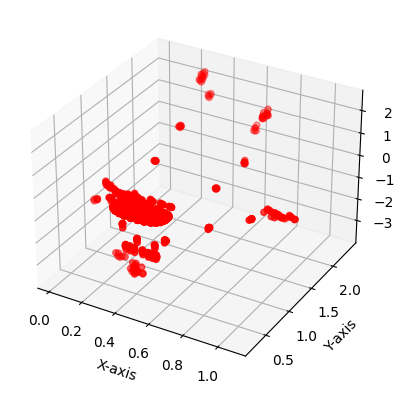

In [ ]:
test = Sign(path + "/train_landmark_files/2044/4294708045.parquet")
test.display()

Z množiny všech landmarků jsme vybrali pouze podmnožinu významných bodů, se kterými budeme pracovat (viz obrázek).

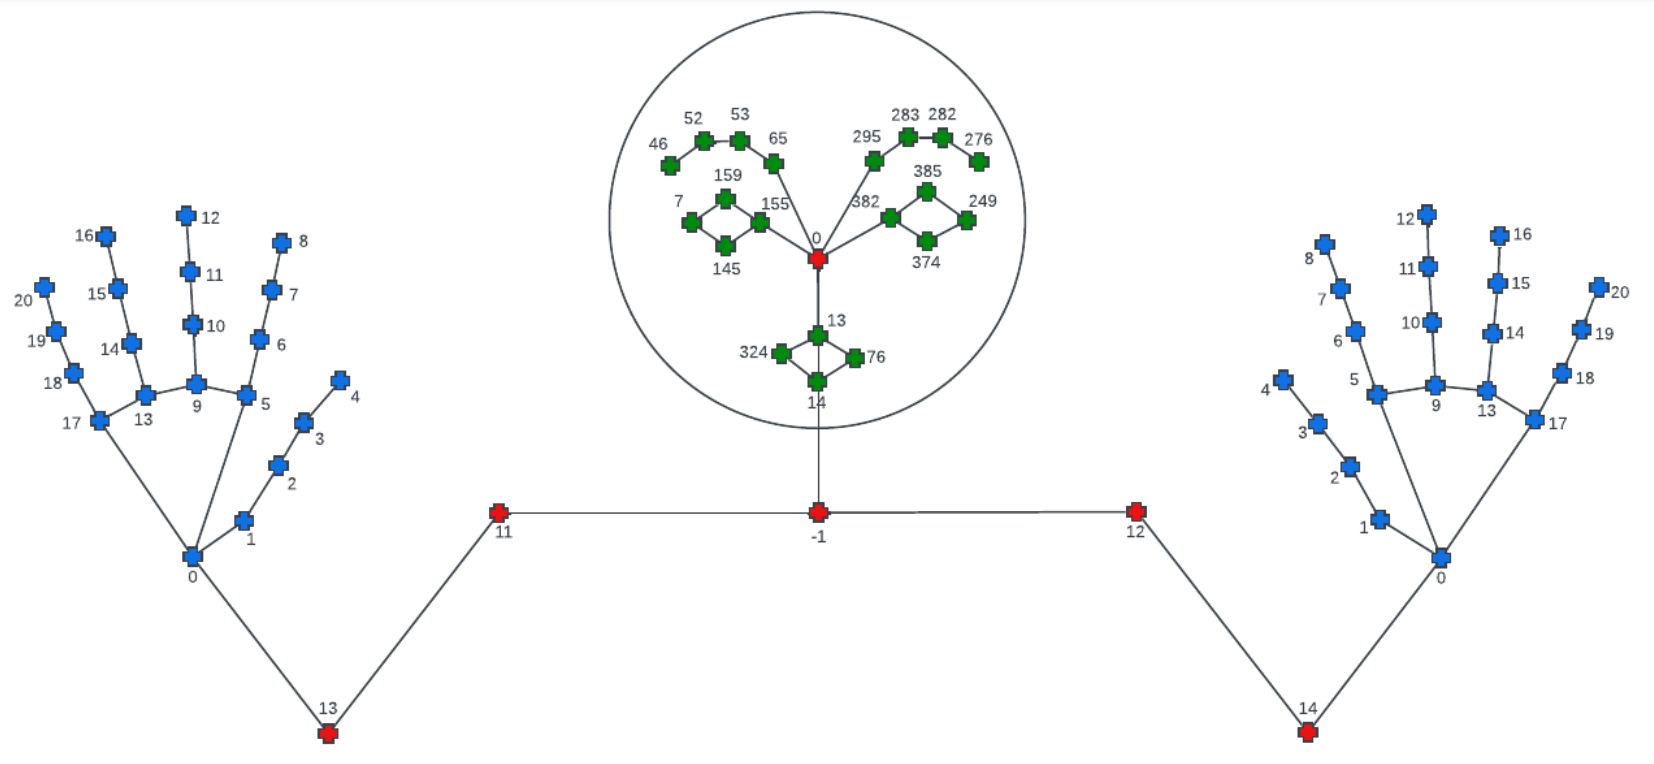

In [ ]:
# Vybrané landmarky na obličeji
selected_landmark_indices = [46, 52, 53, 65, 7, 159, 155, 145, 0,
                             295, 283, 282, 276, 382, 385, 249, 374, 13, 324, 76, 14]

Ještě importujme potřebné knihovny a skripty z git repozáře.

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import math
import sys
import cv2
import io

In [ ]:
!git clone https://github.com/Strojove-uceni/23206-final-sign-language-recognition-in-video

sys.path.append("/content/23206-final-sign-language-recognition-in-video")

Cloning into '23206-final-sign-language-recognition-in-video'...
remote: Enumerating objects: 330, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 330 (delta 20), reused 7 (delta 3), pack-reused 290
Receiving objects: 100% (330/330), 3.37 MiB | 5.15 MiB/s, done.
Resolving deltas: 100% (190/190), done.


# Preprocessing

V průběhu designování neuronové sítě jsme vyzkošeli více typů předzpracování. Tady zmíníme všechny přistupy, tkeré jsme vyzkoušeli, ale dále již budeme pracovat pouze s přístupem, který jsme vyhodnotili jako nejvhodnější.

## Tensorová reprezentace

Jelikože je ukázaný formát dat pro nás nevhodný, protože není invariantní vůči posunutí, a my bychom chtěli aby stejné gesto, vyznakované ve 2 různých částech záběru kamery bylo identické. Rozhodli jsme se proto pro úplně jiný přístup. Problém s invariancí jsme vyřešili tak, že spočítáme vzdálenosti každého bodu s každým, vznikne nám tak vzdálenostní matice, kterou můžeme po normalizaci reprezentovat jako snímek. Dále podobným způsobem vytvoříme matici úhlů a prahovací matici. Tím získáme RGB obraz pro každý snímek z dané sekvence. 

Reading file from /content/drive/MyDrive/ASL-sign_data/train_landmark_files/2044/1479640886.parquet
Successfully read file
DataFrame summary before cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17376 entries, 0 to 17375
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frame           17376 non-null  int16  
 1   row_id          17376 non-null  object 
 2   type            17376 non-null  object 
 3   landmark_index  17376 non-null  int16  
 4   x               16473 non-null  float64
 5   y               16473 non-null  float64
 6   z               16473 non-null  float64
dtypes: float64(3), int16(2), object(2)
memory usage: 746.8+ KB
None

Count of NaN values by column before cleaning:
frame               0
row_id              0
type                0
landmark_index      0
x                 903
y                 903
z                 903
dtype: int64
DataFrame summary after cleaning:
<class 'pan

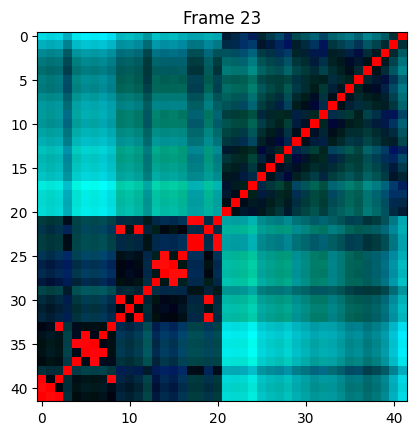

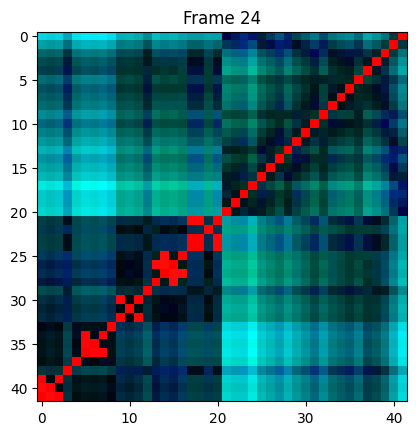

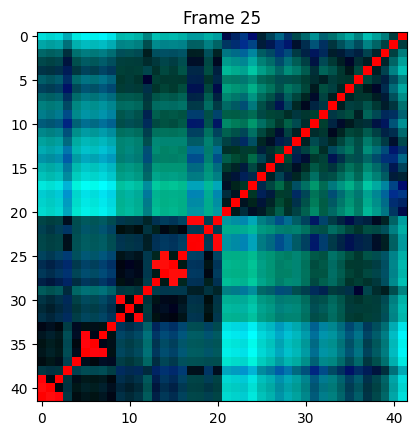

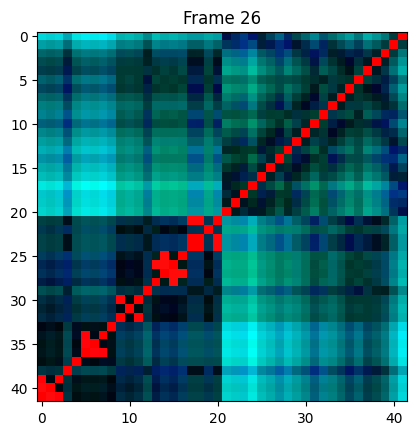

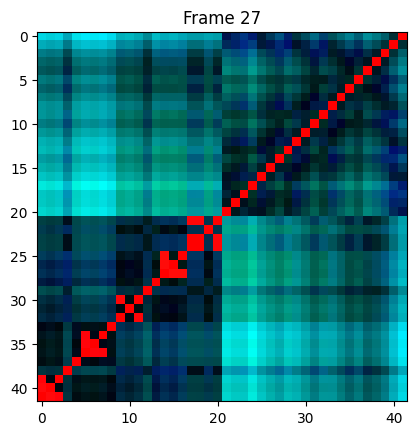

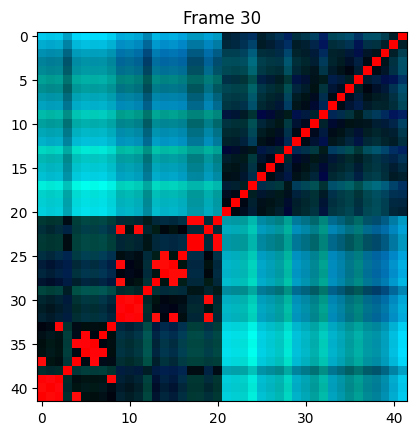

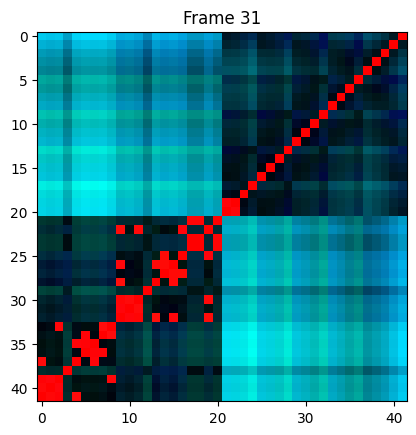

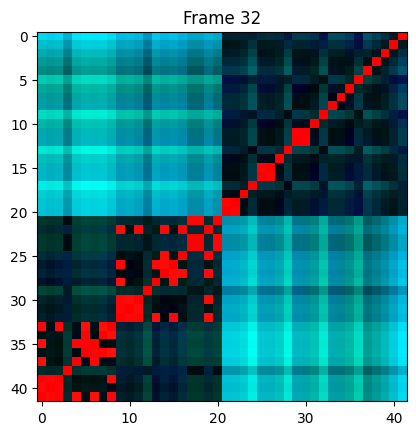

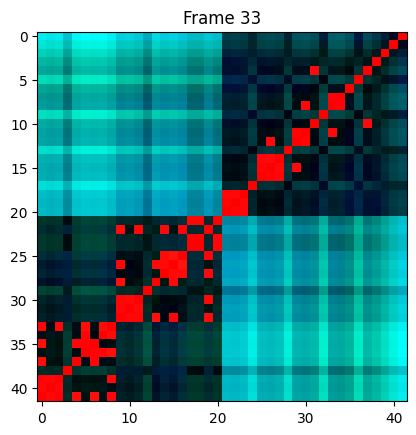

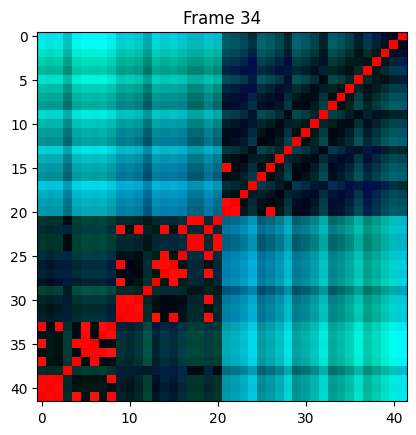

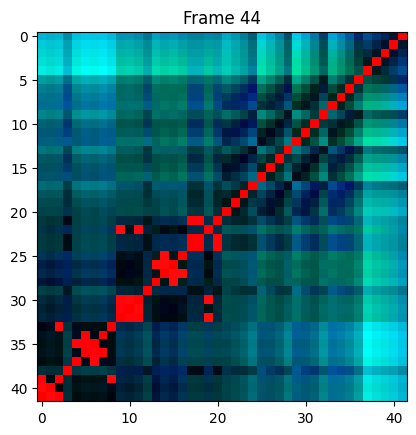

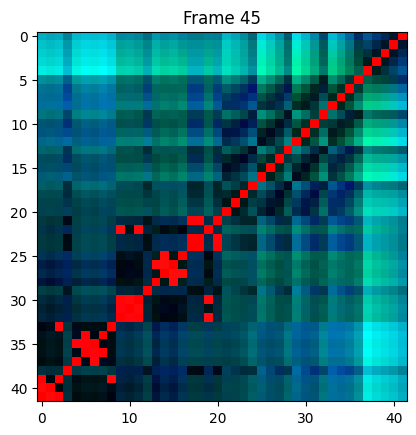

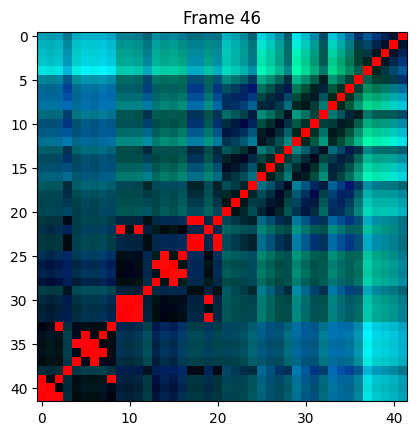

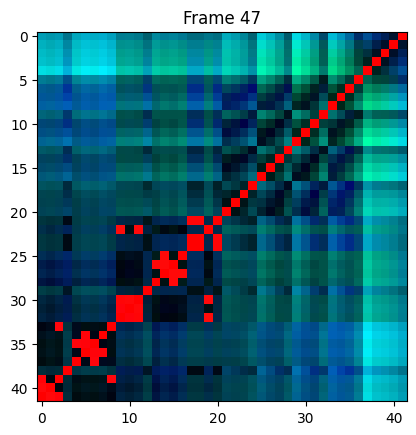

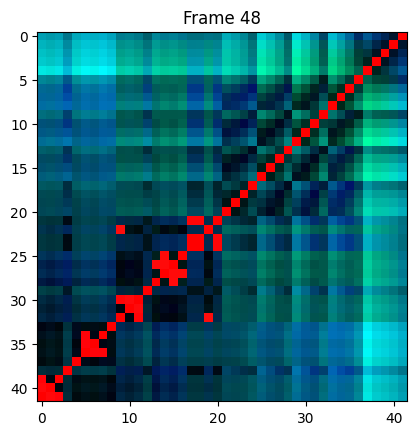

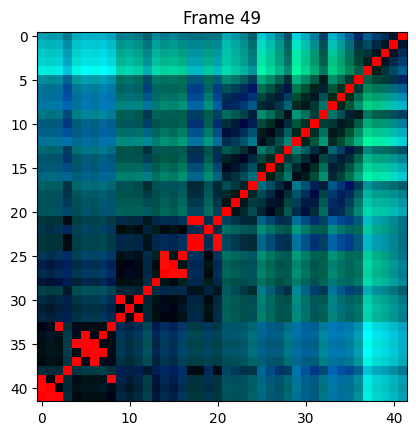

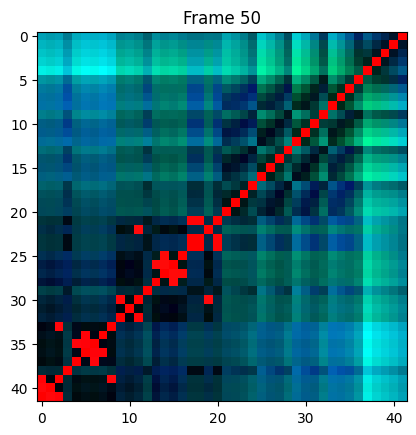

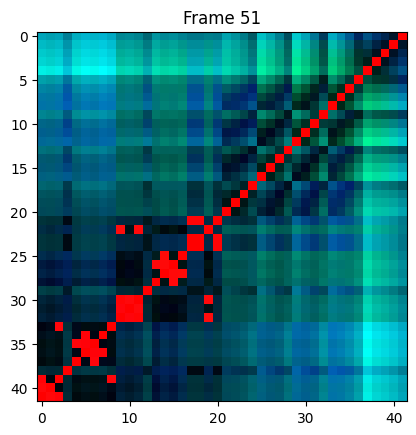

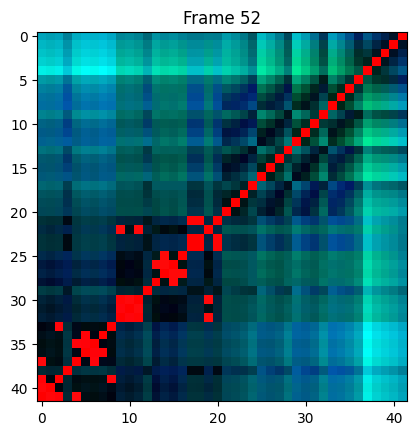

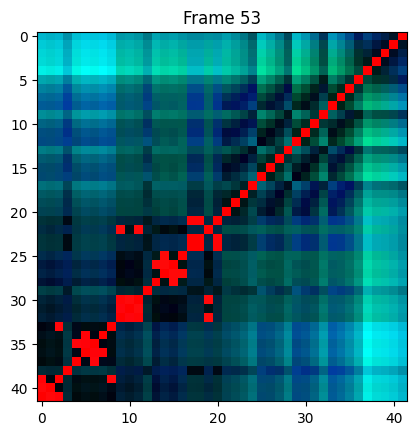

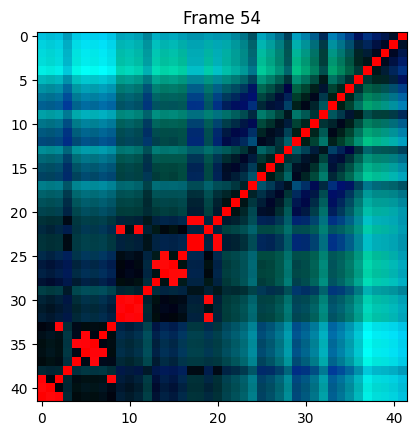

In [ ]:
from processing_v2 import ParquetProcess
parquet_processor = ParquetProcess()
df = parquet_processor.read_parquet(path + "/train_landmark_files/2044/1479640886.parquet")
clean_df = parquet_processor.clean_parquet(df, show_df=False)
parquet_processor.animate_parquet(clean_df, selected_landmark_indices)

Tímto způsobem jsme získali sekvenci RGB snímků vytvořenou ze souřadnic jednotlivých bodů na rukou a obličeji účastníka. Nakonec tyto RGB snímky můžeme naskládat za sebe a vytvořit tak tenzor.

(42, 42, 63)


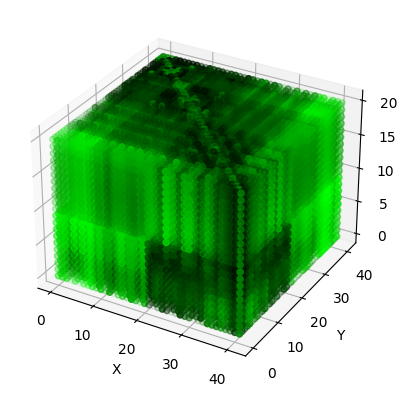

In [ ]:
test_tensor = parquet_processor.create_tensor(clean_df, selected_landmark_indices)
print(test_tensor.shape)
parquet_processor.plot_3d_cube_with_transparency(test_tensor)

Tyto tenzory už můžeme klasifikovat jako jako volumetrické snímky například pomocí 3D konvolučních sítí. Je důležité zmínit, že touto transformací souřadnic na tenzory jsme nepřidali ani neubrali žádnou informaci obsařenou v původních `.parquet` souborech. Jen jsme si připravili půdu pro samotnou klasifikaci, zatímco klasifikovat sekvence souřadnic by mohlo být problematické, klasifikovat tenzory o stejném rozměru je poněkud přímočařejší.
Detaily zpracování a tvorby tenzoru jsou v samotném souboru processing.py včetně dokumentace

Dalším krokem je zpracování všech 90 000 souborů obdobným způsobem a jejich roztřídění. Pro účely třídění jsme použili jednoduchý ShitSort **(nezapomenout přejmenovat!!!)**. Ten prochází složky všech účastníků a všecny soubory v nich, každému souboru přiřadí název znaku podle jména sekvence a přidruženého CSV souboru. Pak každou sekvenci překopíruje do složky s názvem daného znaku. Pokud taková složka neexistuje, vytvoří ji. Zvolili jsme kopírování souborů abychom zachovali původní dataset pro případ že by se vyskytly jiné problémy. Přemisťování souborů by fungovalo obdobně.
Zásadní část kódu je definice maximální délky. Jako již bylo zmíněno, tak 75% souborů má délku do 140 snímků, takže jsme nastavili přesně takovou maximální délku (doplnit ten hezký boxplot s délkami).

In [ ]:
class SortParquets:
    def sort_parquet(self, path, destination_path, df_list, max_length):
        for participant_folder in os.listdir(path + "/train_landmark_files/"):
            path_folder = path + "/train_landmark_files/" + participant_folder + "/"
            for file_name in os.listdir(path_folder):
                file_num = file_name.split(".")[0]
                df_row = df_list[
                    (df_list.participant_id == int(participant_folder)) & (df_list.sequence_id == int(file_num))]
                file_path = path + "/train_landmark_files/" + participant_folder + "/" + file_num + ".parquet"
                if (df_row.length_frames.values[0] > max_length):
                    print('File was skipped:: ', file_path)
                    continue

                sign_name = df_row.sign.values[0]
                destination_folder = os.path.join(destination_path, sign_name)
                if not os.path.exists(destination_folder):
                    os.makedirs(destination_folder)

                # Copy the file
                shutil.copy(file_path, os.path.join(destination_folder, file_name))

                print('File copied to: ', os.path.join(destination_folder, file_name))

Dále jsme vytvořili buffer, jehož účelem je načíst všechna data, potažmo překonvertovat parquet soubory na tenzory a ty tenzory uložit do složek podle názvu znaku. Tato funkcionalita byla přidána především pro testování. Numpy soubory jsou mnohonásobně větší než originální parquet soubory, a tak bychom potřebovali přes 1,5 TB volného úložiště abychom mohli překonvertovat celý dataset. Tento přístup je tedy vyloučený a jak uvidíte později, rozhodli jsme se pro přepočítávání parquet souborů na numpy tenzory přímo v neuronové síti. To ovšem proces trénování značně zpomaluje, takže funkce bufferu byla naprosto zásadní, umožnila nám uložit si omezený počet znaků jako numpy tezory a testovat architektury neuronových sítí v menším počtu a rychleji. Buffer taktéž bere v úvahu maximální délku souboru.

Pro tento přístup jsme vyzkoušeli desítky architektur CNN a CNN-LSTM, ale maximální přesnost na testovacím datasetu, které se nám povedlo dosáhnout byla pouhých $60\%$ při klasifikaci do 5 tříd (znaků). Po četných nezdarech jsme od tohohle přístupu upusitli a zkusili se vydat jinou cestou.

## Maticová reprezentace

Druhým námi vyzkoušeným způsobem předzracování bylo vybrané klíčové body a jejich souřadnice na jednotlivých snímcích reprezentovat jako 3D matici (viz obrázek).

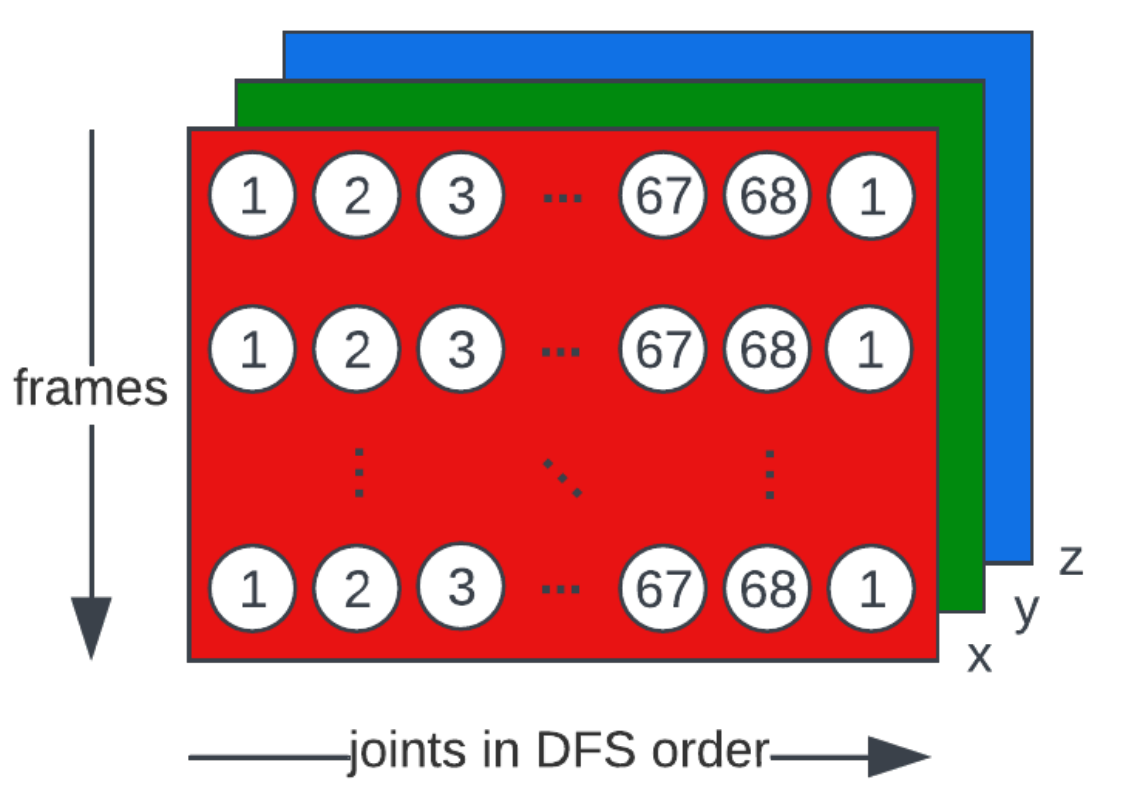

V rámci tohole přístupu jsme vyzkoušeli body ve vodorovné ose seřadit dvěma způsoby.

### Pořadí klíčových bodů pomocí deep-first search
Na základě článku [[1]](#TSSI) jsme vyzkoušeli pořadí landmarků určovat pomocí deep-first search. Metoda předpokládá landmarky a spoje mezi němi reprezentovat jako graf, jenž následně interpretuje jako strom, na kterém provedeme DFS. Graf landmarků ovšem nelze podle standardní teorie grafů interpretovat jako strom a článek bohužel detailně tuto interpretaci nerozebírá. I přesto jsme se pokusili postup napodobit, ale námi vytvořené seřazení ovšem pro náš dataset nepřineslo valné výsledky.

### Osově symetrické pořadí klíčových bodů

V tomhle předzpracování dat jsme landmark body seřadili osově symetricky kolem osy procházející přes střed tváře. Dále chybějící hodnoty v datasetu nahradíme interpolací v případě, že je to možné a v opačném případě je nahradíme nulovou hodnotou. Zvážili jsme a vyzkoušel více typů interpolace. Při prvním pokusu jsme použili interpolaci pomocí nejbližších bodů a při druhém pokusu jsme zvolili lineární interpolaci. Pokud při vytváření dataseu MediaPipe selhalo v detekci landmarků, tak při intuitivní představě dává více smysl použít lineární interpolaci. V případě, že v datech chybí v části snímků souřadnice jedné ruky, ale souřednice obličeje jsou kompletní, tak při použití lineární interpolace bude pohyb obličeje plynulý a pohyb ruky zpomalený. Naopak, kdybychom na stejný příklad použili interpolaci pomocí nejbližsích bodů, tak bude pohyb ruky sekaný.

Příklad předzpracovaných dat (znak pro 'fall') po vykreslení vypadá takhle:
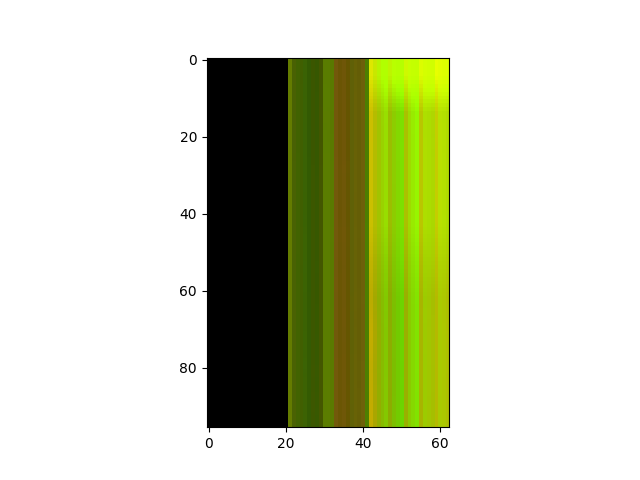

V průběhu designování neuronové sítě jsme vyzkoušeli i variantu předzpracování, ve které jsme odebírali souřadnice ruky, která měla pro daný znak méně NaN hodnot. Tímto přístupem jsme ovšem dosáhli horších výsledků než v případě, že tam souřadnice této ruky necháme a to i v případě, že se daná ruka neobjevila na žádném ze snímků videa a na výstupu předzpracování byly v dané části matice pouze nulové hodnoty. Tenhle přístup se nám ze zmíněných osvědčil nejvíc a dále budeme proto už pouze používat data předzpracovaná tímhle přístupem.

# **Třídy Dataset a DataModule**
Nyní když máme roztříděné a potažmo uložené soubory, můžeme se přesunout k třídám dataset v pytorch lightning. Jelikož pracujeme se dvěma variantami datasetů, buď soubory v `.npy` nebo `.parquet`, tak je potřeba vytvořit 2 třídy Dataset, jednu pro každý formát. Nebylo možné ani pro numpy soubory použít předpřipravené třídy jako například ImageFolder, protože jsou připravené jen na data se třemi kanály. Obě třídy jsou standardní a odpovídající pytorch lightning. Pro numpy soubory bylo potřeba prakticky jen načíst soubor a label, a npy soubor rozšířit o jednu dimenzi za počet kanálů která pak vystupuje ve 3D konvolučních vrstvách.

In [ ]:
!pip install pytorch-lightning
!pip install wandb

import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
import torch
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import StochasticWeightAveraging
from Datasets import ParquetFolderDataset, NpyFolderDataset, AslParquetDataModule, AslNpyDataModule
from Dataset import AslMatrixDataModule
from models import AslLitModel
from pytorch_lightning.tuner import Tuner

In [ ]:
class NpyFolderDataset(Dataset):
    """
    Standard lightning dataset for sorted numpy arrays
    """
    def __init__(self, root_dir, transform=None):
        """
        Initialization of numpy dataset created with buffer.py
        :param root_dir: Path to folder with sorted numpy arrays
        :param transform: Default none for now
        """

        self.root_dir = root_dir
        self.transform = transform
        self.npy_files = []
        self.labels = []
        self.class_to_idx = {}
        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                self.class_to_idx[class_name] = idx
                for file in os.listdir(class_dir):
                    if file.endswith('.npy'):
                        self.npy_files.append(os.path.join(class_dir, file))
                        self.labels.append(idx)

    def __len__(self):
        """
        Returns length of dataset
        :return:
        """
        return len(self.npy_files)

    def __getitem__(self, idx):
        """
        Getitem function loads numpy data and expands dimensions for torch libraries
        :param idx: idx from init
        :return: Sample and lable
        """
        npy_path = self.npy_files[idx]
        label = self.labels[idx]
        sample = np.load(npy_path)
        sample = sample.astype(np.float32)
        sample = np.expand_dims(sample, axis=0)
        if self.transform:
            sample = self.transform(sample)

        return sample, label

Pro parquet soubory jsme využili připravené třídy ParquetProcess která rovnou konvertuje parquet soubory na `.npy` tenzory za chodu. Další postup je totožný s předchozí třídou

In [ ]:
class ParquetFolderDataset(Dataset):
    """
    Standard lighntning dataset for parquet data
    """
    def __init__(self, root_dir, landmarks, transform=None):
        """
        Initialization of dataset made from parquet data
        :param root_dir: Path to folder with sorted parquet data. Sorting done with ShitSort. Data are sorted into
         folders with class name
        :param landmarks: List of selected landmark indices (for detail look at mediapipe indices)
        :param transform: Default none for now
        """
        self.root_dir = root_dir
        self.transform = transform
        self.landmarks = landmarks
        self.parquet_files = []
        self.labels = []
        self.class_to_idx = {}

        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                self.class_to_idx[class_name] = idx
                for file in os.listdir(class_dir):
                    if file.endswith('.parquet'):
                        self.parquet_files.append(os.path.join(class_dir, file))
                        self.labels.append(idx)

    def __len__(self):
        """
        Returns length of dataset
        :return:
        """
        return len(self.parquet_files)

    def __getitem__(self, idx):
        """
        Getitem function, calculates tensor representation of parquet file using ParquetProcess from processing.py
        :param idx: Idx from init
        :return: Sample and lable from parquet dataset folder
        """
        parquet_path = self.parquet_files[idx]
        label = self.labels[idx]
        readed_data = ParquetProcess(parquet_path, self.landmarks, 140)
        sample = readed_data.tensor
        sample = sample.astype(np.float32)
        sample = np.expand_dims(sample, axis=0)
        if self.transform:
            sample = self.transform(sample)

        return sample, label

Obě třídy zahrnují kontrolu správného formátu souborů. Tím že pracujeme s oběma formáty, tak se může snadno stát chyba už při načítání. Tato kontrola tomu má předcházet. Další na řadě jsou Data Moduly, opět dva, pro každý formát souborů. Nejprve třída pro `numpy` pole.

In [ ]:
class AslNpyDataModule(pl.LightningDataModule):
    """
    Standard lightning data module
    """
    def __init__(self, input_dim, num_classes, num_of_workers, data_dir=r"E:\asl-signs\tensors", batch_size: int = 2, val_split: float = 0.2):
        """
        Initialization of data module
        :param input_dim: dimensions of input data (for example (70,70,420)
        :param num_classes: Number of classes
        :param num_of_workers: Number of workers for training of different systems
        :param data_dir: Path to folder with sorted parquet files
        :param batch_size: Batch size, default 2 because of small VRAM, implementation of gradient accumulation
         recommended
        :param val_split: Ratio of data used for validation, default 0.2
        """
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.dims = input_dim
        self.num_classes = num_classes
        self.num_of_workers = num_of_workers
        self.val_split = val_split


    def setup(self, stage: str=None):
        if stage == 'fit' or stage is None:
            full_dataset = NpyFolderDataset(root_dir=self.data_dir)
            print(f"Full dataset size: {len(full_dataset)}")
            val_size = int(len(full_dataset) * 0.2)
            train_size = int(len(full_dataset) * 0.7)
            test_size = len(full_dataset) - train_size - val_size
            self.train_dataset, self.val_dataset, self.test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
            print(f"Train dataset size: {len(self.train_dataset)}")  # Debug print
            print(f"Validation dataset size: {len(self.val_dataset)}")  # Debug print
            print(f"Test dataset size: {len(self.test_dataset)}")  # Debug print

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_of_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_of_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_of_workers)

Jedná se opět o běžný formát pro pytorch lightning. Dochází k rozdělení na trénovací, validační a testovací dataset. Stejné pro `.parquet` soubory.

In [ ]:
class AslParquetDataModule(pl.LightningDataModule):
    """
    Standard lightning data module
    """
    def __init__(self, landmarks_idx, input_dim, num_classes, num_of_workers, data_dir=r"E:\asl-signs\parquets_sorted", batch_size: int = 2, val_split: float = 0.2):
        """
        Initialization of data module
        :param landmarks_idx: List of selected landmark indices used for tensor representation
        :param input_dim: dimensions of input data (for example (70,70,420)
        :param num_classes: Number of classes
        :param num_of_workers: Number of workers for training of different systems
        :param data_dir: Path to folder with sorted parquet files
        :param batch_size: Batch size, default 2 because of small VRAM, implementation of gradient accumulation
         recommended
        :param val_split: Ratio of data used for validation, default 0.2
        """
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.dims = input_dim
        self.num_classes = num_classes
        self.num_of_workers = num_of_workers
        self.val_split = val_split
        self.landmarks = landmarks_idx

    def setup(self, stage: str=None):
        if stage == 'fit' or stage is None:
            full_dataset = ParquetFolderDataset(root_dir=self.data_dir, landmarks=self.landmarks)
            print(f"Full dataset size: {len(full_dataset)}")
            val_size = int(len(full_dataset) * 0.2)
            train_size = int(len(full_dataset) * 0.7)
            test_size = len(full_dataset) - train_size - val_size
            self.train_dataset, self.val_dataset, self.test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
            print(f"Train dataset size: {len(self.train_dataset)}")  # Debug print
            print(f"Validation dataset size: {len(self.val_dataset)}")  # Debug print
            print(f"Test dataset size: {len(self.test_dataset)}")  # Debug print

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_of_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_of_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_of_workers)

Jediná zásadní odlišnost je argument `num_of_workers`. Jelikož trénování bude probíhat na různých systémech, je pro nás výhodné ošetřit možnosti každého takového systému. Jeden ze systémů má grafickou kartu gtx 1050Ti která může vytvořit nejvýše 4 workery. Colab umožňuje vytvořit 11 workerů. Gordon na UTIA umožňuje použít 8 workerů. Tyto rozdíly v možnostech každého systému vedou k tomu že bylo potřeba nastavit optimální počet workerů pro co nejrychlejší trénování.
Všechny tyto 4 třídy jsou obsažené v souboru Datasets.py, abychom je mohli volat rovnou a nemuseli je znovu opisovat do modelů.

## Příprava dat

Uveďme příklady předzpracování dat, který ovšem kvůli časové náročnosti zde nebudeme pouštět. Data jsme již pro trénování připravili a budeme neuronové sítě trénovat na připravených datech. Popřípadě lze generování dat spustit odkomentováním kódu na posledním řádku v buňkách níže. Tento kód pustí vygenerování dat pro vybrané znaky v proměnné `signs`.

In [ ]:
signs = ['bad', 'fall', 'not', 'go', 'can', 'wet', 'grandma', 'grandpa', 'look', 'no']

### Ve formátu tenzoru

In [ ]:
from buffer import ParquetData

data_load = ParquetData()
# data_load.preprocess_all(path, df_train, selected_landmark_indices, signs, 140)

### V formátu matice

In [ ]:
from Secondary_buffer import ParquetData

data_load = ParquetData()
# data_load.preprocess_all(path, df_train, selected_landmark_indices, signs, 96)

# 3DCNN
První model, na otestování všech předešlých metod je pouze modifikovanou verzí konvoluční sítě používané pro klasifikaci MNIST datasetu. Liší se jen v dimenzionalitě. Všechny modely jsou obsažené v souboru `models.py`.

In [ ]:
from torch import nn
from torch.nn import functional as F
from torchmetrics import Accuracy
import torch.optim as optim

In [ ]:
class AslLitModel(pl.LightningModule):
    def __init__(self, input_shape, num_classes, learning_rate=3e-4):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.conv1 = nn.Conv3d(1, 32, 3, 1)
        self.conv2 = nn.Conv3d(32, 32, 3, 1)
        self.conv3 = nn.Conv3d(32, 64, 3, 1)
        self.conv4 = nn.Conv3d(64, 64, 3, 1)

        self.pool1 = nn.MaxPool3d(3)
        self.pool2 = nn.MaxPool3d(3)

        n_sizes=self._get_output_shape(input_shape)

        self.fc1 = nn.Linear(n_sizes, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, self.num_classes)

        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)

    def _get_output_shape(self, shape):

        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self._feature_extractor(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    def _feature_extractor(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        return x

    def forward(self, x):

       x = self._feature_extractor(x)
       x = x.view(x.size(0), -1)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = F.log_softmax(self.fc3(x), dim=1)
       return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        # metric
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# 3D ResNet
---
Dalším pokusem byl 3D ResNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torch.cuda
import wandb
from torchmetrics import Accuracy
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import StochasticWeightAveraging
from Datasets import ParquetFolderDataset, NpyFolderDataset, AslParquetDataModule, AslNpyDataModule
from models import AslLitModel, AslLitModel2, AslLitModel3, AslLitModel4
from pytorch_lightning.tuner import Tuner
from torch.optim.lr_scheduler import ReduceLROnPlateau


class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock3D, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)

        # Second Convolutional Layer
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        # Skip Connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet3D(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet3D, self).__init__()
        self.in_channels = 64

        # Initial Convolution
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(64)

        # Stages
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Average Pooling
        self.avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.drop = nn.Dropout(0.2)
        # Fully Connected Layer
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.drop(out)
        return out


class LitResNet3D(pl.LightningModule):
    def __init__(self, num_classes=10, lr=1e-3):
        super(LitResNet3D, self).__init__()
        self.num_classes = num_classes
        self.model = ResNet3D(ResidualBlock3D, [1, 1, 1, 1], num_classes=self.num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = lr
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(y_hat, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(y_hat, y), prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.accuracy(y_hat, y), prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

Tento model vyprodukoval nejlepší výsledek pro test accuracy 0,6 a to pro pouhé 4 třídy, pro více znaků přesnost odpovídala náhodnému tipu. Ukázalo se že tento přístup je nevhodný, zpracování dat do tenzorů, byť sympatické na papíře, není vhodné pro klasifikaci. Velmi komplikuje řešení NaN hodnot, a jejich nahrazení nulami způsobuje podmíněnost vysokým počtem nul. Zároveň je 3DCNN velmi náročná na trénování, požadavky na paměť jsou vysoké, trénování trvá velmi dlouho i pro malý počet tříd a všeobecně se jednalo o slepou cestu

# RNN

Jako další krok jsme vyzkoušeli použít RNN. V prvním pokus jsme k CNN architektuře přidali LSTM vrstvu, která může zachytit vzory v čase nebo sekvencích, což je užitečné pro úlohy, jako je klasifikace videa. Tím jsme získali CNN-LSTM neuronovou síť, která je bhodná primárně pro úlohy, které zahrnují prostorová data a následné sekvenční zpracování. Klíčové je pečlivě navrhnout architekturu tak, aby prostorové rysy extrahované sítí CNN byly efektivně kondenzovány a předány do LSTM pro časovou analýzu.

In [ ]:
class AslCnnRnnModel(pl.LightningModule):
    def __init__(self, input_shape, hidden_dim, num_classes, n_layers, learning_rate=3e-4):
        super(AslCnnRnnModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.scaler = torch.cuda.amp.GradScaler()

        # CNN
        self.cnn = nn.Sequential(nn.Conv2d(3, 64, 3, stride=1, padding=1),
                                    nn.MaxPool2d(2),
                                    nn.BatchNorm2d(64),
                                    nn.Conv2d(64, 64, 3, stride=1, padding=1),
                                    nn.MaxPool2d(2),
                                    nn.BatchNorm2d(64),
                                    nn.Conv2d(64, 128, 3, stride=1, padding=1),
                                    nn.MaxPool2d(2),
                                    nn.BatchNorm2d(128),
                                    nn.Conv2d(128, 256, 3, stride=1, padding=1),
                                    nn.MaxPool2d(2),
                                    nn.BatchNorm2d(256))

        self.cnn.add_module('flatten', Flatten())
        self.cnn.add_module('fc1', nn.Linear(4608, 2048))
        self.cnn.add_module('drop', nn.Dropout(0.4))
        self.cnn.add_module('fc2', nn.Linear(2048, 1024))

        # RNN
        self.rnn = nn.LSTM(input_size=1024, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)

        # Classification layer
        self.classifier = nn.Linear(self.hidden_dim, self.num_classes)
        self.loss_fn = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)

    def forward(self, x):
        # CNN
        cnn_out = self.cnn(x)
        r_in = cnn_out.unsqueeze(1)

        # RNN
        rnn_out, _ = self.rnn(r_in)
        rnn_out2 = rnn_out[:, -1, :]

        # Classifier
        out = self.classifier(rnn_out2)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', self.accuracy(y_hat, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', self.accuracy(y_hat, y), prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.accuracy(y_hat, y), prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)


Vyzkoušeli jsme vícero architektur tohohle typu. Výslednou testovací přesnost pro vybrané architektury shrnuje následující graf:

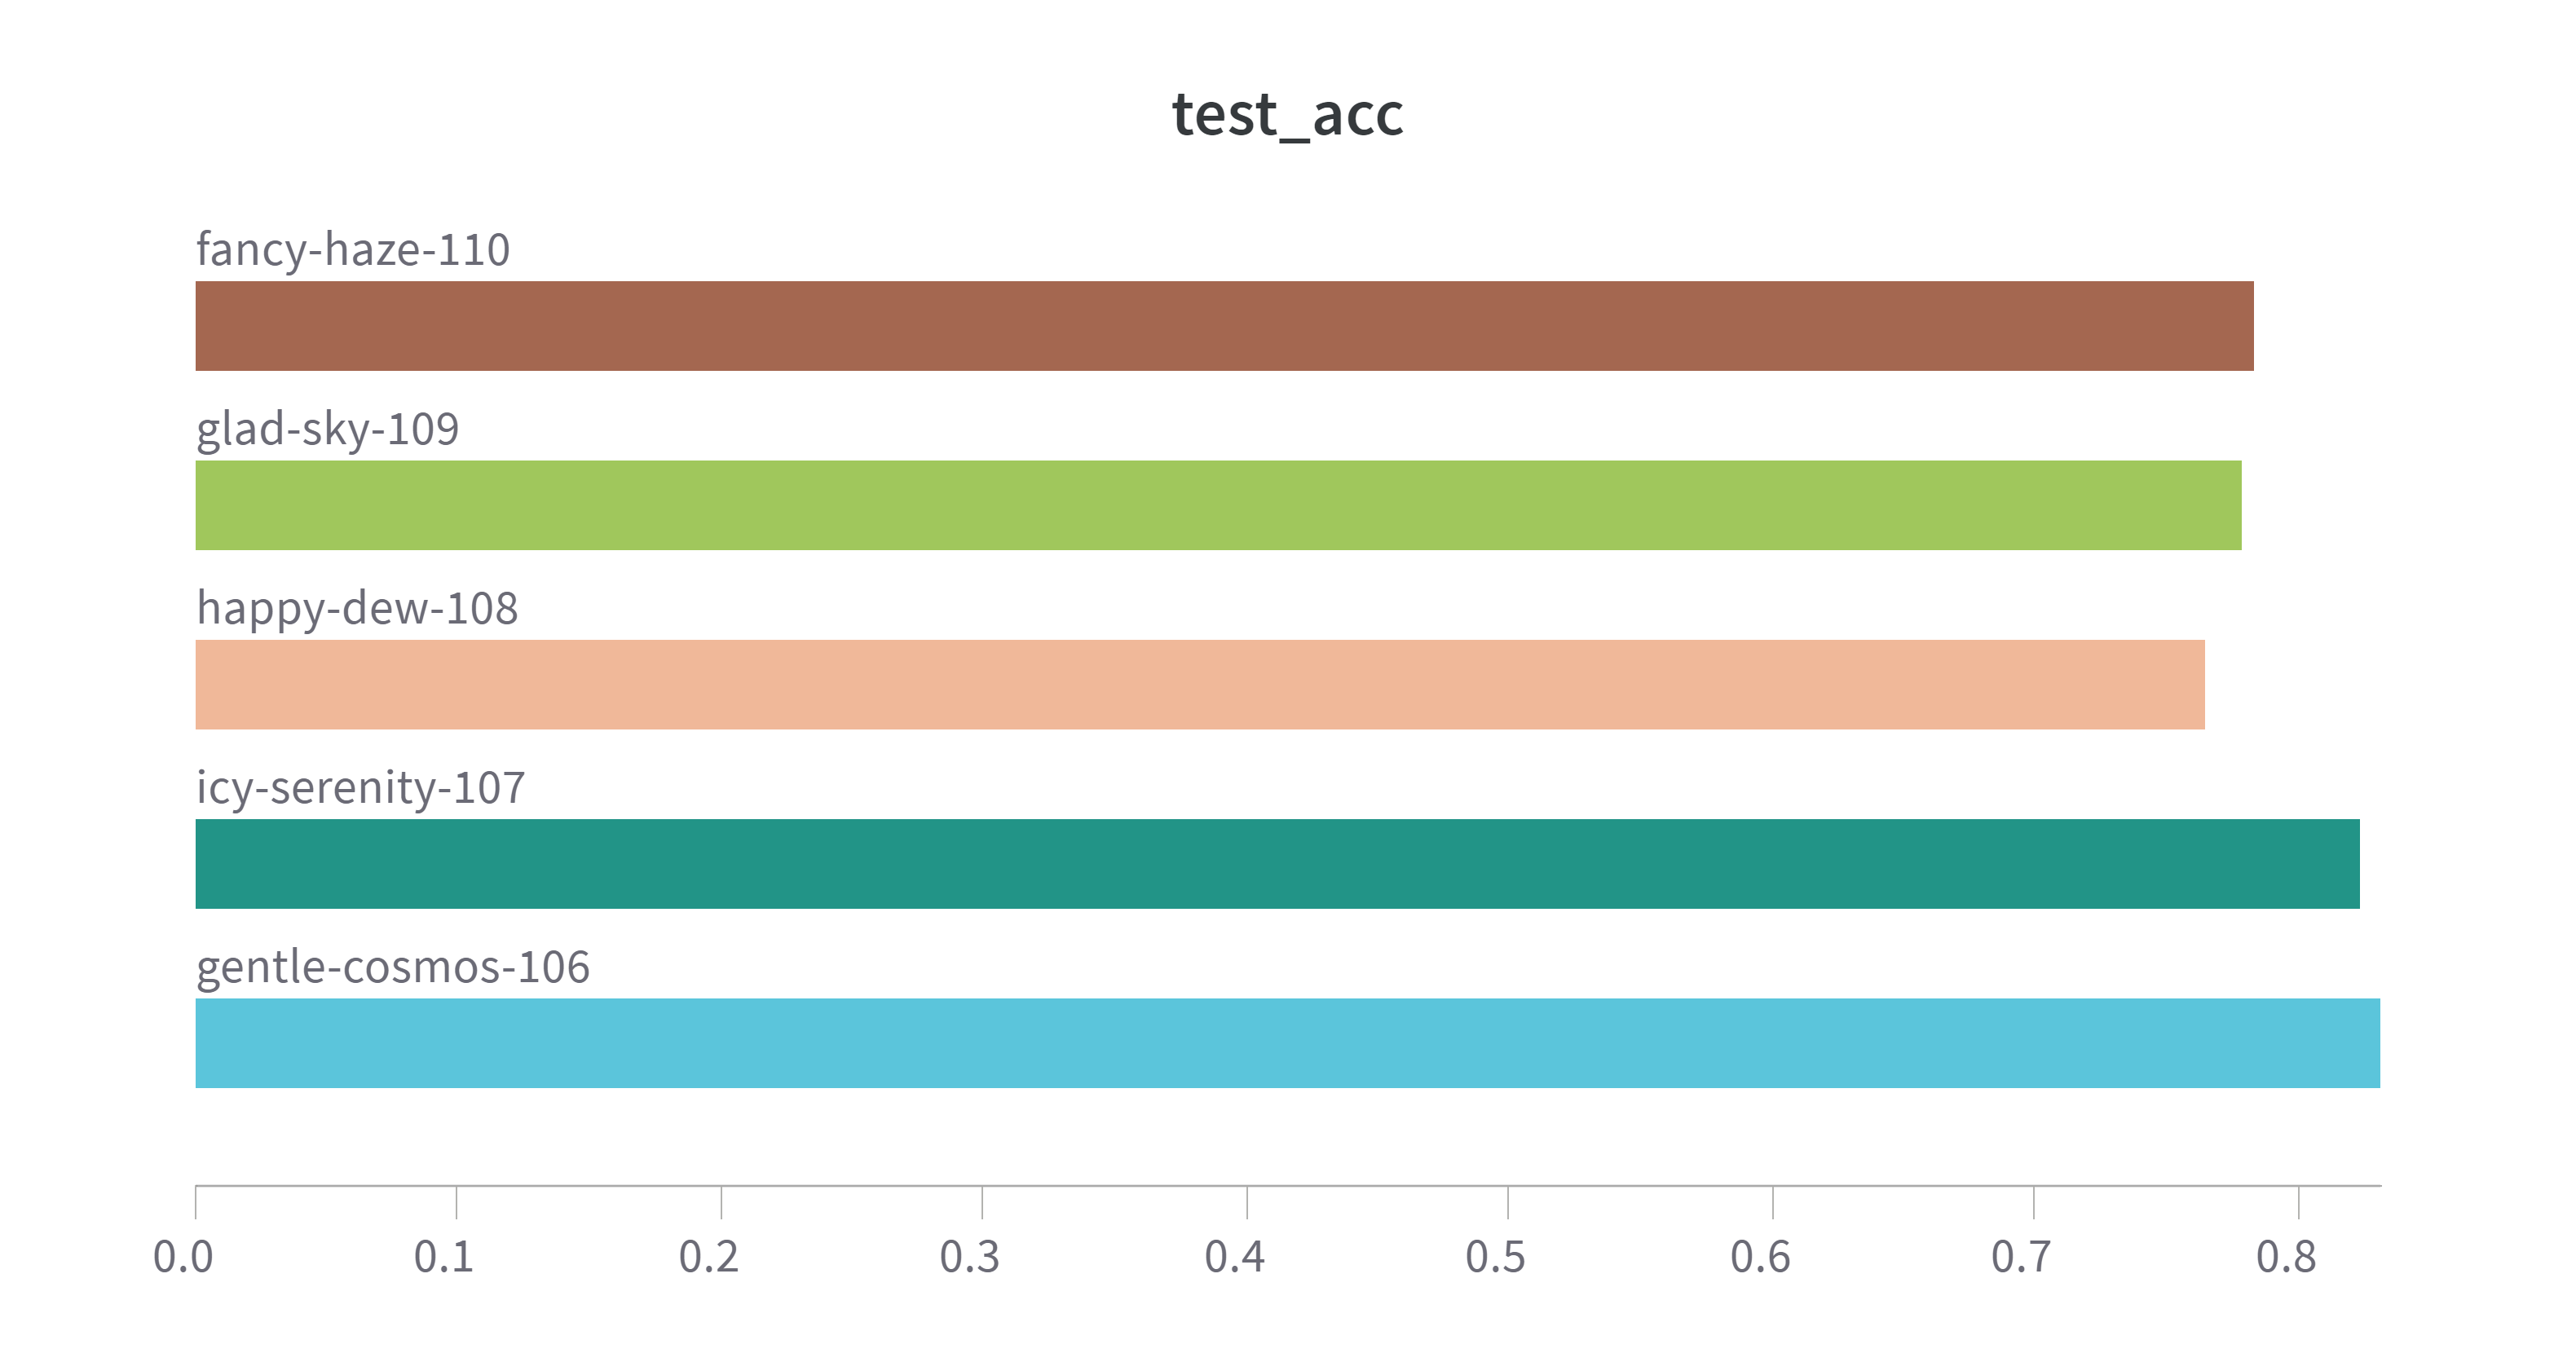

Nejlepší model dosáhl přesnosti $83.2\%$ při klasifikaci do 10 tříd. Ovšem při spuštění trénování na více třídách nebyla neuronová síť schopna udržet krok s ostatními modely.

# 2DCNN
---
2D CNN modelů jsme vyzkoušeli mnoho, v souboru Models.py jsou k dispozici 2 nejlepší, zde uvádíme pouze ten se kterým jsme dosáhli dobrých výsledků. Jedná se o relativně jednoduchý konvoluční model, největší vliv na kvalitu výsledků měli dropout a learning rate. Typicky se ukazovalo že 1e-3 je příliš vysoký learning rate. Otestovali jsme i batch size finder a learning rate finder v pytorch lightning knihovně, ale nepodávali příliš dobré výsledky. Více se osvědčilo experimentovat manuálně.

In [ ]:
class AslLitModelMatrix2(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.num_classes = num_classes

        # Define the CNN layers and fully connected layers according to the architecture
        self.layer1 = nn.Sequential(nn.Conv2d(3, 64, 3, stride=1, padding=1),
                                    nn.MaxPool2d(2),
                                    nn.BatchNorm2d(64))

        self.layer2 = nn.Sequential(nn.Conv2d(64, 64, 3, stride=1, padding=1),
                                    nn.MaxPool2d(2),
                                    nn.BatchNorm2d(64))

        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=1, padding=1),
                                    nn.MaxPool2d(2),
                                    nn.BatchNorm2d(128))

        self.layer4 = nn.Sequential(nn.Conv2d(128, 256, 3, stride=1, padding=1),
                                    nn.MaxPool2d(2),
                                    nn.BatchNorm2d(256))

        self.global_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(4608, 1024)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, self.num_classes)

        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.learning_rate = learning_rate

    def forward(self, x):
        x = self.layer1(x)
        x = self.drop(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.relu(x)

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(y_hat, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(y_hat, y), prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.accuracy(y_hat, y), prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-3)

        def lambda_epoch(epoch):
            if epoch < 10:
                return 1.0
            elif 10 <= epoch < 20:
                return 0.5
            else:
                return 0.1

        scheduler_lr = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)
        scheduler_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {'scheduler': scheduler_lr, 'interval': 'epoch'},
            'lr_scheduler': {'scheduler': scheduler_plateau, 'interval': 'epoch', 'monitor': 'val_loss'},
            'gradient_clip_val': 0.5,
        }

# 2DCNN výsledky
---
Trénování jsme prováděli na různém počtu tříd, zde uvedeme nejzajímavější výsledky. Začneme trénováním na 10 třídách. Learning rate byl nastavený na 3e-3, dropout na 0,5. 11 epoch a batch size 32. V druhém běhu jsme zvýšili dropout a přidali 4 epochy. Tato drobná změna zvýšila test accuracy z 0,69 na 0,84, což už je přijatelný výsledek, ovšem na pouhých 10 třídách.

 Run summary:

             epoch 17
             test_acc 0.84118
             test_loss 0.52622
             train_acc 0.625
             train_loss 2.04088
             trainer/global_step 1201
             val_acc 0.80412
             val_loss 0.61393

Další test jsme provedli na 50 třídách. Nastavení zůstalo stejné.

 Run summary:

               epoch 17
               test_acc 0.67849
               test_loss 1.22606
               train_acc 0.28125
               train_loss 2.4627
               trainer/global_step 6033
               val_acc 0.65765
               val_loss 1.44644

Vidíme že test accuracy už pro 50 tříd klesne na pouhých 67%. Pro 250 tříd se dostáváme sotva na 50%. Jedná se tedy o další slepou cestu


# Custom ResNet
---
Následující 2 třídy shrnují implementace modelu ResNet, jak předtrénovaného pro transfer learning, tak nepředtrénovaného pro vlastní trénování a modifikace.

**Upozornění: Budete-li zkoušet spustit ResNet, použijte předtrénovaný. Je sice nestabilní kvůli relativně malému množství dat, ale transfer learning je nesrovnatelně rychlejší, trénování vlastního ResNetu trvá přes 22 hodin na GTX 1050ti**

Modifikovaný ResNet bez předtrénování obsahuje navíc 2 dropout vrstvy, které výrazně stabilizují trénování, přičemž nám zůstávají výhody ResNetu. Výsledky jsou opravdu působivé, i bez transfer learningu se dostáváme na validation accuracy přes 50% po pouhých 2 epochách. Při správném nastavení learning rate a dropoutu jsme se po 10 epochách dostali na validation accuracy přes 75%, test accuracy jsme během experimentů dostali až 79%. Více než jakýkoliv předchozí model a současně více než jakýkoliv jiný vyzkoušený. Dostat test accuracy přes 80% se nám bohužel nepodařilo

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from pytorch_lightning import LightningModule
from torchvision import models
from torchmetrics import Accuracy
import pytorch_lightning as pl

class ImageClassifier(LightningModule):
    def __init__(self, num_classes: int = 250, learning_rate: float = 0.001):
        super().__init__()

        # Use pretrained model for robustness
        self.backbone = models.resnet50(pretrained=True)
        num_ftrs = self.backbone.fc.in_features
        self.num_classes = num_classes

        # Remove the final layer of the model
        layers = list(self.backbone.children())[:-1]
        self.backbone = nn.Sequential(*layers)

        # Replace it with a new linear layer (classification head)
        self.classifier = nn.Linear(num_ftrs, num_classes)
        self.learning_rate = learning_rate
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)


    def forward(self, x):
        x = self.backbone(x)
        x = torch.flatten(x, start_dim=1)  # Flatten features vector
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(y_hat, y), prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.accuracy(y_hat, y), prog_bar=True)
        return loss



    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

class BasicBlock(nn.Module):
    """
    Basic Block of ResNet
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # First convolution block of the Basic Block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second convolution block of the Basic Block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(pl.LightningModule):
    """
    ResNet class for constructing the model
    """
    def __init__(self, block, num_blocks, num_classes=250, learning_rate=0.001):
        super().__init__()
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.in_channels = 64


        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(3072, num_classes)
        self.drop1 = nn.Dropout(0.7)
        self.drop2 = nn.Dropout(0.4)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.drop1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.drop2(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(y_hat, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(y_hat, y), prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.accuracy(y_hat, y), prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-3)

        def lambda_epoch(epoch):
            if epoch < 15:
                return 1.0
            elif 10 <= epoch < 20:
                return 0.5
            else:
                return 0.1

        scheduler_lr = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)
        scheduler_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {'scheduler': scheduler_lr, 'interval': 'epoch'},
            'lr_scheduler': {'scheduler': scheduler_plateau, 'interval': 'epoch', 'monitor': 'val_loss'},
            'gradient_clip_val': 0.5,
        }

def ResNet50(num_classes=250, learning_rate=0.001):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes, learning_rate)

# ResNet Výsledky
---


# Trénování

Pro trénování modelu jsme do sdílené složky nahráli již předzpracovaná data, abychom běh celého notebooku urychlili. Zde přidáváme pouze kód pro trénování finálního model. Ostatní modely je možné trénovat pomocí skriptů `CNN_drft.py` a `CNN_LSTM_draft.py` v repozitáři. Dále nedoporučujeme povádět celé trénování kvůli časové náročnosti.

In [ ]:
def main():
    selected_landmark_indices = [46, 52, 53, 65, 7, 159, 155, 145, 0,
                                295, 283, 282, 276, 382, 385, 249, 374, 13, 324, 76, 14]

    params = {"landmarks": selected_landmark_indices,
              "input_dim": (70, 70, 420),
              "model_input": (1, 70, 70, 420),
              "num_classes": 10,
              "num_of_workers": 4,
              "path": (path + "\tensors"),
              "batch": 4,
              "val_split": 0.2,
              "learning_rate": 3e-2,
              "epochs": 20,
              "precision": 16,
              "accumulated gradient batches": 8,
              "Stochastic Weight Averaging": 1e-2,
              "AutoSet": False,
              "log_key": '6b4346cf1caf31e2c470b0f4b7e338da7bf74825'}

    wandb.login(key=params["log_key"])

    dm = AslNpyDataModule(params["input_dim"], params["num_classes"], params["num_of_workers"], params["path"], params["batch"], params["val_split"])
    dm.setup()

    model = AslLitModel(params["model_input"], dm.num_classes, params["learning_rate"])

    wandb_logger = WandbLogger(project='ASL', job_type='train')
    wandb_logger.experiment.config.update({
        "model_name": "Draft_no_acc_local",
        "input_dim": params["input_dim"],
        "model_input": params["model_input"],
        "num_classes": params["num_classes"],
        "num_of_workers": params["num_of_workers"],
        "batch": params["batch"],
        "val_split": params["val_split"],
        "learning_rate": params["learning_rate"],
        "epochs": params["epochs"],
        "precision": params["precision"],
        "accumulated gradient batches": params["accumulated gradient batches"],
        "Stochastic Weight Averaging": params["Stochastic Weight Averaging"],
    })
    checkpoint_callback = pl.callbacks.ModelCheckpoint()
    trainer = pl.Trainer(logger=wandb_logger, max_epochs=params["epochs"],
                         callbacks=[StochasticWeightAveraging(swa_lrs=params["Stochastic Weight Averaging"])], precision=params["precision"], accumulate_grad_batches=params["accumulated gradient batches"],
                         )
    if params["AutoSet"]:
        tuner = Tuner(trainer)
        tuner.scale_batch_size(model)
        tuner.lr_find(model)

    trainer.fit(model, dm)
    trainer.test(dataloaders=dm.test_dataloader())
    wandb.finish()


if __name__ == '__main__':
    main()

Používáme běžný přístup ukládání všech hyperparametrů do slovníku pro snadné experimentování. Zde se objevil zásadní problém. Naše data mají rozměr 70x70x420 pixelů. To je na trénování neuronové sítě opravdu hodně, trénování trvá dlouho a paměť GPU není dostačující. Tyto problémy adresujeme použitím Automated Mixed precision a také Gradient Accumulation. Obě tyto metody zrychlily trénování až 4x v případě sestavy Gordon. Dále využíváme Stochastic Weight Averaging pro efektivnější trénování dostatečně diskriminativního modelu. Pro loggování používáme Weights and Biases knihovnu.

Tento model nepodává požadované výsledky pro všech 250 tříd, ovšem dosahuje použitelné výsledky pro 10 tříd, takže na otestování všech metod byl postačující.

In [ ]:
model_name = "2DCNN_10_class_84_prct.ckpt"

# Finální model
Naším finalním modelem byla modifikace ResNetu.

# Inference
Inferenci chceme provádět v reálněm čase (možná). Pro tento účel jsme připravili soubor LiveFeedv4. Zdůrazňujeme, že toto na colabu nebude fungovat, colab nemá přístup k webkameře v reálném čase.
Nejprve si připravíme třídu WebcamStream která bude sbírat snímky z web kamery.

In [ ]:
class WebcamStream:
    # initialization method
    def __init__(self, stream_id=0):
        self.stream_id = stream_id  # default is 0 for main camera

        # opening video capture stream
        self.vcap = cv2.VideoCapture(self.stream_id)
        if self.vcap.isOpened() is False:
            print("[Exiting]: Error accessing webcam stream.")
            exit(0)
        fps_input_stream = int(self.vcap.get(5))  # hardware fps
        print("FPS of input stream: {}".format(fps_input_stream))

        # reading a single frame from vcap stream for initializing
        self.grabbed, self.frame = self.vcap.read()
        if self.grabbed is False:
            print('[Exiting] No more frames to read')
            exit(0)
        # self.stopped is initialized to False
        self.stopped = True
        # thread instantiation
        self.t = Thread(target=self.update, args=())
        self.t.daemon = True  # daemon threads run in background

    # method to start thread
    def start(self):
        self.stopped = False
        self.t.start()

    # method passed to thread to read next available frame
    def update(self):
        while True:
            if self.stopped is True:
                break
            self.grabbed, self.frame = self.vcap.read()
            if self.grabbed is False:
                print('[Exiting] No more frames to read')
                self.stopped = True
                break
        self.vcap.release()

    # method to return latest read frame
    def read(self):
        return self.frame

    # method to stop reading frames
    def stop(self):
        self.stopped = True

Dále připravíme třídu pro extrakci landmarků ze streamu webkamery pomocí knihovny mediapipe

In [ ]:
class LiveFeed:
    def __init__(self, selected_landmark_indices, depth=140):
        self.mp_face_mesh = mp.solutions.face_mesh
        self.mp_hands = mp.solutions.hands
        self.face_mesh = self.mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)
        self.hands = self.mp_hands.Hands(static_image_mode=False, max_num_hands=2)
        self.selected_landmark_indices = selected_landmark_indices
        self.depth = depth
        self.tensor = None
        self.initialized = False

    def extract_landmarks(self, image, frame_number=0):
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image with the face_mesh and hands models
        face_results = self.face_mesh.process(image_rgb)
        hand_results = self.hands.process(image_rgb)

        # Initialize a list to store the data for DataFrame creation
        landmarks_list = []

        # Extract face landmarks if any faces are detected
        if face_results.multi_face_landmarks:
            for idx in self.selected_landmark_indices:  # Loop through your predefined selected indices
                landmark = face_results.multi_face_landmarks[0].landmark[idx]
                landmarks_list.append({
                    'frame': frame_number,
                    'row_id': f'{frame_number}-face-{idx}',
                    'type': 'face',
                    'landmark_index': idx,
                    'x': landmark.x,
                    'y': landmark.y,
                    'z': landmark.z
                })

        # Extract hand landmarks if hands are detected
        if hand_results.multi_hand_landmarks:
            for hand_no, hand_landmarks in enumerate(hand_results.multi_hand_landmarks):
                for idx, landmark in enumerate(hand_landmarks.landmark):
                    landmarks_list.append({
                        'frame': frame_number,
                        'row_id': f'{frame_number}-hand{hand_no}-{idx}',
                        'type': 'right_hand',
                        'landmark_index': idx,
                        'x': landmark.x,
                        'y': landmark.y,
                        'z': landmark.z
                    })

        # Create a DataFrame from the list of landmarks
        landmarks_df = pd.DataFrame(landmarks_list)

        return landmarks_df

    def live_gesture(self, dataframe, frame_number):
        coordinates=parquet_proccessor.extract_landmarks(dataframe,frame_number,self.selected_landmark_indices)
        dist_matrix=parquet_proccessor.distance(coordinates)
        angle_marix=parquet_proccessor.angle_matrix(coordinates)
        trsh_matrix=parquet_proccessor.treshold_matrix(dist_matrix)
        rgb=parquet_proccessor.make_img(trsh_matrix,angle_marix,dist_matrix)
        plt.imshow(rgb)
        plt.show(block=False)
        plt.pause(0.01)  # Pause to display the current frame's matrix
        plt.clf()
        return rgb


    def tensor_creation(self, image):
        image_array = np.array(image)
        if not self.initialized:
            # Initialize the tensor with the first image shape and set the initialized flag
            m, n, channels = image_array.shape
            self.tensor = np.zeros((m, n, channels * self.depth))
            for i in range(self.depth):
                self.tensor[:, :, i*channels:(i+1)*channels] = image_array
            self.initialized = True
        else:
            m, n, _ = self.tensor.shape[:3]  # Current tensor dimensions
            if image_array.shape[0] == m and image_array.shape[1] == n:
                # Shift the tensor to remove the oldest image and make space for the new one
                self.tensor = np.roll(self.tensor, -3, axis=2)
                # Insert the new image at the 'freshest' end of the tensor
                self.tensor[:, :, -3:] = image_array
            else:
                print("Image dimensions do not match tensor dimensions, skipping this image.")


        return self.tensor

Výstup z kamery a předzpracování snímku pak vypadá takhle:

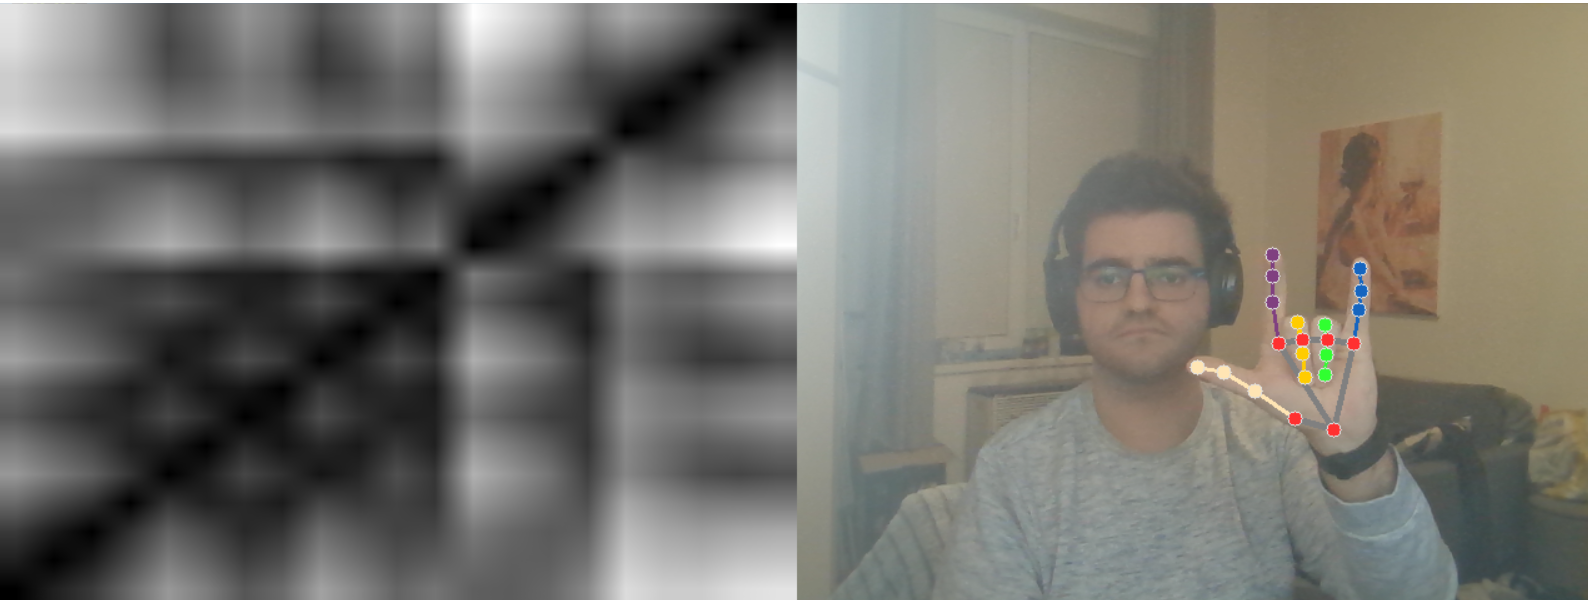

Nakonec tyto třídy použijeme pro vytvoření živého stremu a inferenci

In [ ]:
selected_landmark_indices = [46, 52, 53, 65, 7, 159, 155, 145, 0,
                            295, 283, 282, 276, 382, 385, 249, 374, 13, 324, 76, 14]
parquet_proccessor=ParquetProcess()
live_feed=LiveFeed(selected_landmark_indices,depth=140)
webcam_stream = WebcamStream(stream_id=0)  # 0 id for main camera
webcam_stream.start()
# processing frames in input stream
num_frames_processed = 0
start = time.time()
while True :
    if webcam_stream.stopped is True :
        break
    else :
        frame = webcam_stream.read()
        lnd=live_feed.extract_landmarks(frame, frame_number=num_frames_processed)
        print(lnd)
        rgb=live_feed.live_gesture(lnd,num_frames_processed)
        # TODO: přepsat na parquet matrix!
        tensor=live_feed.tensor_creation(rgb)
        print(tensor.shape)

    num_frames_processed += 1
    # displaying frame
    #cv2.imshow('frame' , frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
end = time.time()
webcam_stream.stop() # stop the webcam stream

Povšimněte si, že jsme byli nuceni použít multithreading. Jedno vlákno zvlášť pro sběr snímků z kamery, druhé vlákno pro extrakci landmarků. Pravděpodobně bude potřeba použít třetí vlákno nebo gpu k samotné  inferenci. Toto bylo potřeba pro zachování snímkovací frekvence.

# References

<a name="TSSI">[1]</a> Laines, Mendoza, Ruiz (2020). [Isolated Sign Language Recognition based on Tree Structure Skeleton Images.](https://openaccess.thecvf.com/content/CVPR2023W/LatinX/papers/Laines_Isolated_Sign_Language_Recognition_Based_on_Tree_Structure_Skeleton_Images_CVPRW_2023_paper.pdf) Tecnologico de Monterrey, School of Sciences and Engineering, 15(4)

<a name="CNN">[2]</a> Yong Du, Yun Fu, and Liang Wang. [Skeleton based action recognition with convolutional neural network](https://arxiv.org/pdf/2301.13360.pdf). In 2015 3rd IAPR Asian conference on pattern recognition (ACPR), pages 579–583. IEEE, 2015